In [1]:
import os
import sys
if 'google.colab' in sys.modules:
    import gdown
    if 'torch' not in sys.modules:
        !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
    if 'skia-python' not in sys.modules:
        !pip3 install skia-python

    if os.getcwd() != '/content/DeepGraphemics':
        !git clone https://github.com/bensapirstein/DeepGraphemics.git
        %cd DeepGraphemics/

    url = 'https://drive.google.com/drive/folders/1X3ERUGyhMZo_ZlHApI1XkjcZAVcnTRNd?usp=drive_link'

    gdown.download_folder(url)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# unzip several databases based on category and letter.

categories = ["base", "moderate", "rotation", "rich_moderate", "rich_rotation"]

for ds_type in categories:
    root_dir = f"datasets/{ds_type}_dataset"
    if not os.path.exists(root_dir):
        zipped_data = f"{root_dir}.zip"
        !unzip -q $zipped_data -d datasets/

In [3]:
import numpy as np
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torch.nn.functional as F
from src.capsnet import CapsNet, ReconstructionNet, CapsNetWithReconstruction, MarginLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 128
test_batch_size = 1000
epochs = 100
save_every = 20
lr = 0.001
no_cuda = False
seed = 42
log_interval = 10
routing_iterations = 3
with_reconstruction = True
reconstruction_alpha = 1.
n_classes = 22 # 22 letters in the baseline alphabet

cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [4]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from src.datasets import GraphemesDataset

img_transform = transforms.Compose([
    transforms.ToTensor()
])

ds_type = "rich_rotation"
letter = None # Run on all letters
root_dir = f"datasets/{ds_type}_dataset"

train_dataset = GraphemesDataset(root_dir, train=True, by_letter=letter, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = GraphemesDataset(root_dir, train=False, by_letter=letter, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

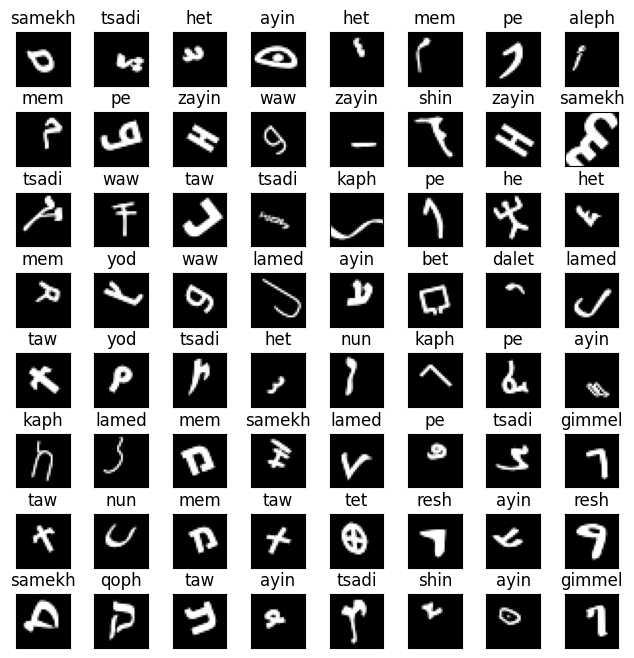

In [6]:
import src.plot as plot

fig, axes = plot.dataset_first_n(train_dataset, 64,
                                 show_classes=True,
                                 class_labels=train_dataset.classes,
                                 nrows=8, hspace=0.5, cmap='gray')

In [ ]:
model = CapsNet(routing_iterations, n_classes)

if with_reconstruction:
    reconstruction_model = ReconstructionNet(16, n_classes)
    model = CapsNetWithReconstruction(model, reconstruction_model)

if cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=15, min_lr=1e-6)

loss_fn = MarginLoss(0.9, 0.1, 0.5)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        if with_reconstruction:
            output, probs = model(data, target)
            reconstruction_loss = F.mse_loss(output, data.view(-1, 784))
            margin_loss = loss_fn(probs, target)
            loss = reconstruction_alpha * reconstruction_loss + margin_loss
        else:
            output, probs = model(data)
            loss = loss_fn(probs, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.data.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)

        if with_reconstruction:
            output, probs = model(data, target)
            reconstruction_loss = F.mse_loss(output, data.view(-1, 784), size_average=False).data.item()
            test_loss += loss_fn(probs, target, size_average=False).data.item()
            test_loss += reconstruction_alpha * reconstruction_loss
        else:
            output, probs = model(data)
            test_loss += loss_fn(probs, target, size_average=False).data.item()

        pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test_loss = test()
    scheduler.step(test_loss)
    if epoch % save_every == 0:
        torch.save(model.state_dict(),
                    'alphabet_{:03d}_model_dict_{}routing_reconstruction{}.pth'.format(epoch, routing_iterations,
                                                                            with_reconstruction))